# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Data loading
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


In [65]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from scipy.stats import randint
from scipy.interpolate import interp1d
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.preprocessing import robust_scale
from scipy.stats import shapiro
import scipy.stats as stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn import svm


def check_inf_and_nan(data, column):
    """Check if inf and nan values are present"""
    if np.isinf(data[f'{column}']).any() == True:
        return True
    if np.isnan(data[f'{column}']).any() == True:
        return True
    return False

def calculate_p_values(data):
    """Calculates the p_values for every feature in the data between the lipoma and liposarcoma group"""
    data_lipoma = data[data['label'] == 'lipoma']
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    p_values = pd.Series(0.0,index=data.columns)
    for column in data.columns:
        if any(isinstance(value, str) for value in data[f'{column}']):
            p_values = p_values.drop(f'{column}')
            continue
        if check_inf_and_nan(data, column):
            p_values = p_values.drop(f'{column}')
            continue
        stat, p = (stats.mannwhitneyu(data_lipoma[f'{column}'],data_liposarcoma[f'{column}'], axis=0))
        if p == 1.0:
            p_values = p_values.drop(f'{column}')
            continue
        p_values[f'{column}'] = p
    p_values = p_values.sort_values()
    return p_values

def split_data(data,split=5,n=5):
    train_ratio = 1/split
    split_length_max = int(np.round(train_ratio * (data.shape[0]) * n))
    features = data.drop(columns=['label'])
    label = data['label']
    split_length_min = int(np.round(train_ratio * (data.shape[0]) * (n-1)))
    features_test = features[split_length_min:split_length_max]
    features_train = features.loc[~features.index.isin(features_test.index)]
    label_test = label[split_length_min:split_length_max]
    label_train = label.loc[~label.index.isin(label_test.index)]
    return features_train,features_test,label_train,label_test

In [4]:
# Correlation between features
data_lipoma = data[data['label'] == 'lipoma']
data_lipoma.pop('label')
corr_lipoma = data_lipoma.corr(method='pearson')
no_corr_lipoma = (corr_lipoma>-0.5) & (corr_lipoma<0.5)

data_liposarcoma = data[data['label'] == 'liposarcoma']
data_liposarcoma.pop('label')
corr_liposarcoma = data_liposarcoma.corr(method='pearson')
no_corr_liposarcoma = (corr_liposarcoma>-0.5) & (corr_liposarcoma<0.5)

no_corr = no_corr_lipoma & no_corr_liposarcoma
no_corr_count = 0
for index, Series in no_corr.iterrows():
    for counts in Series:
        if counts == True:
            no_corr_count += 1

no_corr_amount = (no_corr_count)/2
feature_pairs = ((len(no_corr.index)-1)*len(no_corr.index))/2
no_corr_percentage = no_corr_amount / feature_pairs * 100

print(f'The amount of feature pairs without correlation is {no_corr_amount} out of {feature_pairs} feature pairs ({no_corr_percentage:5.4}%).')
no_corr.head()

p_values = calculate_p_values(data)
# Naive Bayes classifiers
X = data[p_values.index[0:10]]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
y_predict_gnb = gnb.predict(X_test)
accuracy_gnb = accuracy_score(y_test, y_predict_gnb)
print(f"Accuracy of the Gaussian naive bayes classifier is: {accuracy_gnb}")

bnb = naive_bayes.BernoulliNB()
bnb.fit(X_train, y_train)
y_predict_bnb = bnb.predict(X_test)
accuracy_bnb = accuracy_score(y_test, y_predict_bnb)
print(f"Accuracy of the Bernoulli naive bayes classifier is: {accuracy_bnb}") # binarizes the data, since the input of the features is not binary

# conb = naive_bayes.ComplementNB() --> not possible, since the input needs to be only integers
# canb = naive_bayes.CategoricalNB() --> not possible, since the input needs to be categorical
# mnb = naive_bayes.MultinomialNB() --> not possible, since the input needs to be only integers

The amount of feature pairs without correlation is 92524.0 out of 121278.0 feature pairs (76.29%).
found a string in column "label". Did not use this column for the classifier
Accuracy of the Gaussian naive bayes classifier is: 0.7714285714285715
Accuracy of the Bernoulli naive bayes classifier is: 0.6857142857142857


Processing Split 1
Optimal k for Split 1: 9
Test Accuracy for Split 1 with optimal k (9): 0.5217
Test AUC for Split 1 with optimal k (9): 0.5644
Processing Split 2
Optimal k for Split 2: 9
Test Accuracy for Split 2 with optimal k (9): 0.5217
Test AUC for Split 2 with optimal k (9): 0.5644
Processing Split 3
Optimal k for Split 3: 9
Test Accuracy for Split 3 with optimal k (9): 0.5217
Test AUC for Split 3 with optimal k (9): 0.5644
Processing Split 4
Optimal k for Split 4: 5
Test Accuracy for Split 4 with optimal k (5): 0.5652
Test AUC for Split 4 with optimal k (5): 0.5606
Processing Split 5
Optimal k for Split 5: 5
Test Accuracy for Split 5 with optimal k (5): 0.5652
Test AUC for Split 5 with optimal k (5): 0.5606


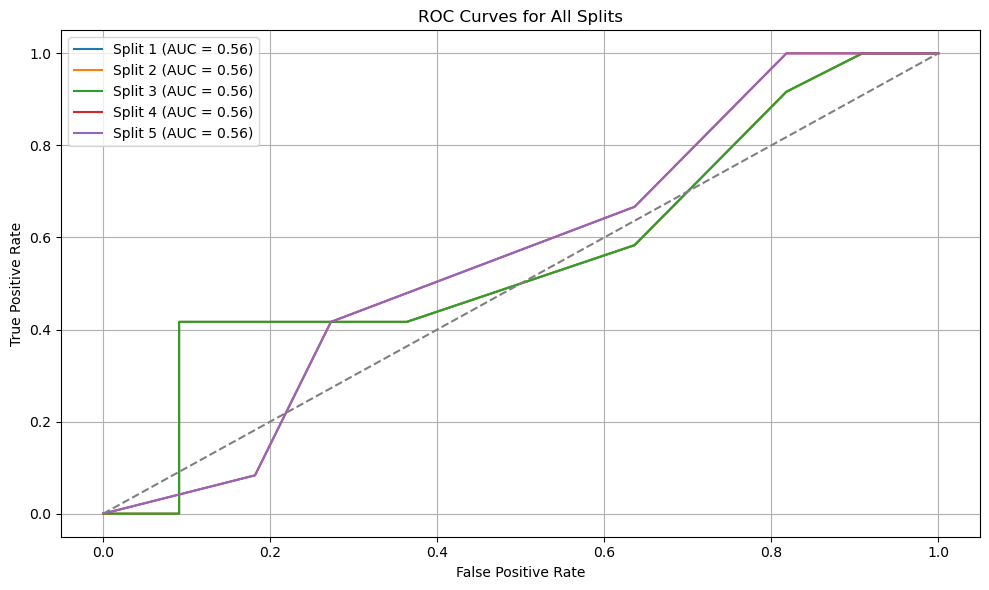

In [ ]:
# Functie om de data op te splitsen in train en test met random_state
# def split_data(data, train_ratio, random_state=42):
#     np.random.seed(random_state)  # Zorg ervoor dat de splits consistent zijn
#     split_length = int(np.round(train_ratio * data.shape[0]))
#     features = data.drop(columns=['label'])
#     label = data['label']
    
#     # Shuffle the data before splitting
#     shuffled_indices = np.random.permutation(data.shape[0])
#     features = features.iloc[shuffled_indices]
#     label = label.iloc[shuffled_indices]
    
#     # Split de data
#     features_train = features[:split_length]
#     features_test = features[split_length:]
#     label_train = label[:split_length]
#     label_test = label[split_length:]
    
#     return features_train, features_test, label_train, label_test

# Veronderstel data met labels 'lipoma' en 'liposarcoma'
data_lipoma = data[data['label'] == 'lipoma']
data_liposarcoma = data[data['label'] == 'liposarcoma']

# Split de data in training (80%) en testing (20%) per klasse
split_lipoma = split_data(data_lipoma, 0.8)
split_liposarcoma = split_data(data_liposarcoma, 0.8)

# Combineer de trainingsdata van zowel lipoma als liposarcoma
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
]

# Initialiseer RobustScaler voor feature scaling
scaler = RobustScaler()

# Fit de scaler op de trainingsdata en pas deze toe op de testdata
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

# Label encoding voor de AUC-berekening (veronderstel binaire classificatie)
encoder = LabelEncoder()
label_train_encoded = encoder.fit_transform(label_train)
label_test_encoded = encoder.transform(label_test)

# StratifiedKFold initialisatie voor 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Verkiesbare k-waarden voor cross-validation
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# Opslaan van de ROC data voor elke split
roc_data_all_splits = []

# Loop door de 5 verschillende splits
for split_index, (train_index, val_index) in enumerate(skf.split(features_train_scaled, label_train_encoded)):
    print(f"Processing Split {split_index + 1}")

    # Extract training and validation data for this split
    X_train_fold, X_val_fold = features_train_scaled[train_index], features_train_scaled[val_index]
    y_train_fold, y_val_fold = label_train_encoded[train_index], label_train_encoded[val_index]

    # Verkrijg de cross-validation scores voor verschillende k-waarden
    cv_scores = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train_fold, y_train_fold, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # Vind de optimale k-waarde voor deze split
    optimal_k = k_values[cv_scores.index(max(cv_scores))]
    print(f"Optimal k for Split {split_index + 1}: {optimal_k}")

    # Train het model met de beste k-waarde op de volledige trainingsdata (80%)
    knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
    knn_final.fit(features_train_scaled, label_train_encoded)

    # Maak voorspellingen op de testset (20%)
    test_predictions = knn_final.predict(features_test_scaled)

    # Bereken de testaccuracy
    test_accuracy = accuracy_score(label_test_encoded, test_predictions)
    print(f"Test Accuracy for Split {split_index + 1} with optimal k ({optimal_k}): {test_accuracy:.4f}")

    # Bereken de ROC curve en AUC voor de testset
    y_pred_prob = knn_final.predict_proba(features_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(label_test_encoded, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"Test AUC for Split {split_index + 1} with optimal k ({optimal_k}): {roc_auc:.4f}")

    # Sla de ROC data op voor deze split (zorg ervoor dat de data goed wordt toegevoegd)
    roc_data_all_splits.append((fpr, tpr, roc_auc))

# Plot de ROC curves voor alle splits
plt.figure(figsize=(10, 6))

# Loop door de opgeslagen ROC data en plot elke curve
for split_index, (fpr, tpr, roc_auc) in enumerate(roc_data_all_splits):
    # Plot elke ROC curve van de splits
    plt.plot(fpr, tpr, label=f'Split {split_index + 1} (AUC = {roc_auc:.2f})')

# Voeg de diagonaal toe (willekeurige voorspellingen)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Voeg labels en een titel toe aan de grafiek
plt.title('ROC Curves for All Splits')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Toon de legend voor de ROC curves
plt.legend()

# Zet het raster aan voor betere leesbaarheid
plt.grid(True)

# Zorg ervoor dat alles goed wordt weergegeven
plt.tight_layout()
plt.show()

found a string in column "label". Did not use this column for the classifier
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 75}
Accuracy: 0.782608695652174, Specificity: 0.8181818181818182, Sensitivity: 0.75
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 75}
Accuracy: 0.7391304347826086, Specificity: 0.5833333333333334, Sensitivity: 0.9090909090909091
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 93}
Accuracy: 0.6956521739130435, Specificity: 0.7272727272727273, Sensitivity: 0.6666666666666666
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 93}
Accuracy: 0.8260869565217391, Specificity: 0.8333333333333334, Sensitivity: 0.8181818181818182
Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 7, 'n_estimators': 103}
Accuracy: 0.6521739130434783, Specificity: 0.8181818181818182, Sensitivity: 0.5


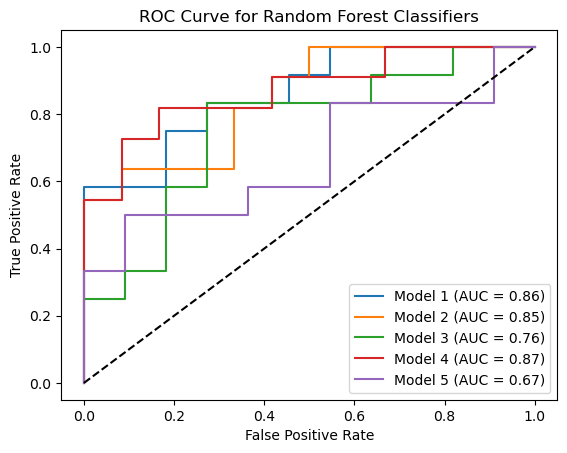

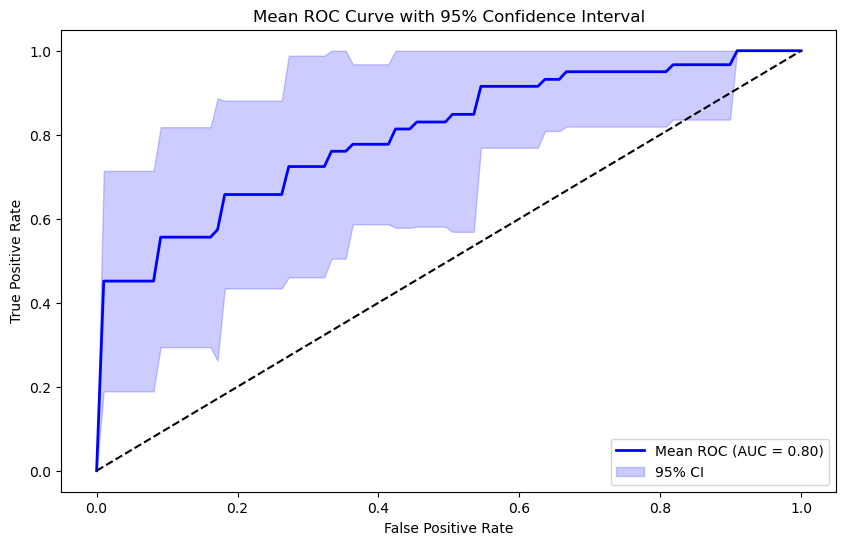

Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

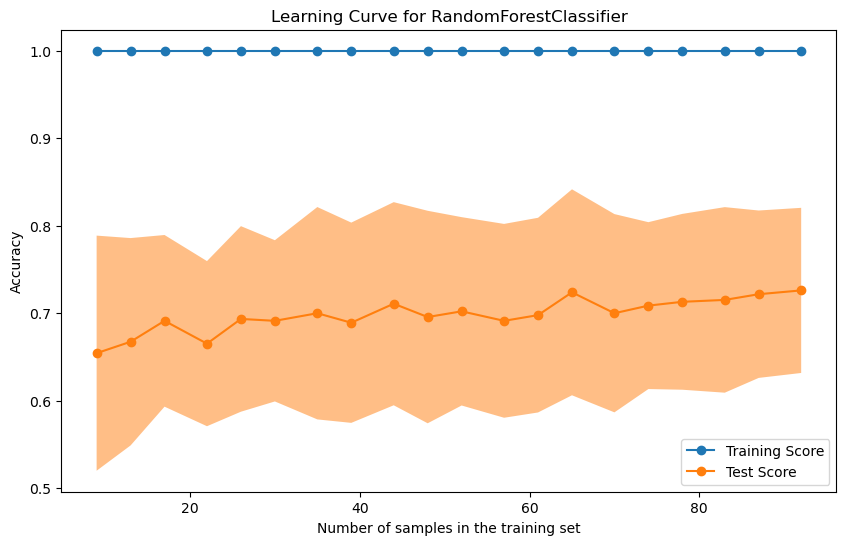

In [60]:
param_dist = {'n_estimators': randint(1,150),
              'max_depth': randint(2,10),
              'min_samples_leaf': randint(3,10)}

model = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=42)

p_values = calculate_p_values(data)
p_values_used = p_values[:60].index
columns_to_keep = list(p_values_used) + ['label']
data_used = data[columns_to_keep]
data_lipoma = data_used[data_used['label'] == 'lipoma']
data_liposarcoma = data_used[data_used['label'] == 'liposarcoma']

n = 5
accuracy = []
specificity = []
sensitivity = []
all_roc = np.linspace(0, 1, 100)
roc_list = []
best_rf_complete = []
for i in range(1,n+1):
    split_lipoma = split_data(data_lipoma, n, i)
    split_liposarcoma = split_data(data_liposarcoma, n, i)
    features_train, features_test, label_train, label_test = [
        pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
        ]

    rand_search.fit(features_train, label_train)
    best_rf = rand_search.best_estimator_
    best_rf_complete.append(best_rf)
    print('Best hyperparameters:',  rand_search.best_params_)

    label_pred = best_rf.predict(features_test)
    label_prob = best_rf.predict_proba(features_test)[:, 1]

    accuracy.append(accuracy_score(label_test, label_pred))
    specificity.append(recall_score(label_test, label_pred, pos_label='lipoma'))
    sensitivity.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
    print(f'Accuracy: {accuracy[i-1]}, Specificity: {specificity[i-1]}, Sensitivity: {sensitivity[i-1]}')

    fpr, tpr, _ = roc_curve(label_test, label_prob, pos_label='liposarcoma')
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Model {i} (AUC = {roc_auc:.2f})')

    interp_roc = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(all_roc)
    interp_roc[0] = 0
    roc_list.append(interp_roc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifiers')
plt.legend(loc='lower right')
plt.show()

roc_array = np.array(roc_list)
mean_roc = np.mean(roc_array, axis=0)
std_roc = np.std(roc_array, axis=0)
ci_upper = np.minimum(mean_roc + 1.96 * std_roc, 1)
ci_lower = np.maximum(mean_roc - 1.96 * std_roc, 0)
mean_auc = auc(all_roc, mean_roc)

plt.figure(figsize=(10, 6))
plt.plot(all_roc, mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
plt.fill_between(all_roc, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with 95% Confidence Interval')
plt.legend(loc='lower right')
plt.show()

# for i in range(1):
#     tree = best_rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=features_train.columns,  
#                                filled=True,  
#                                max_depth=3, 
#                                impurity=True, 
#                                proportion=False)
#     graph = graphviz.Source(dot_data)
#     display(graph)


fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__}")

Feature 'PREDICT_original_hf_entropy' is statistically significant (p-value: 0.0008)
Feature 'PREDICT_original_logf_entropy_sigma1' is statistically significant (p-value: 0.0011)
Feature 'PREDICT_original_logf_entropy_sigma5' is statistically significant (p-value: 0.0022)
Feature 'PREDICT_original_logf_entropy_sigma10' is statistically significant (p-value: 0.0024)
Feature 'PREDICT_original_tf_LBP_entropy_R3_P12' is statistically significant (p-value: 0.0031)
Feature 'PREDICT_original_tf_LBP_entropy_R8_P24' is statistically significant (p-value: 0.0038)
Feature 'PREDICT_original_tf_LBP_entropy_R15_P36' is statistically significant (p-value: 0.0039)
Feature 'PREDICT_original_tf_Gabor_entropy_F0.05_A0.0' is statistically significant (p-value: 0.0051)
Feature 'PREDICT_original_tf_Gabor_entropy_F0.05_A0.79' is statistically significant (p-value: 0.0052)
Feature 'PREDICT_original_tf_Gabor_entropy_F0.05_A1.57' is statistically significant (p-value: 0.0056)
Feature 'PREDICT_original_tf_Gabor_

c:\Users\michi\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


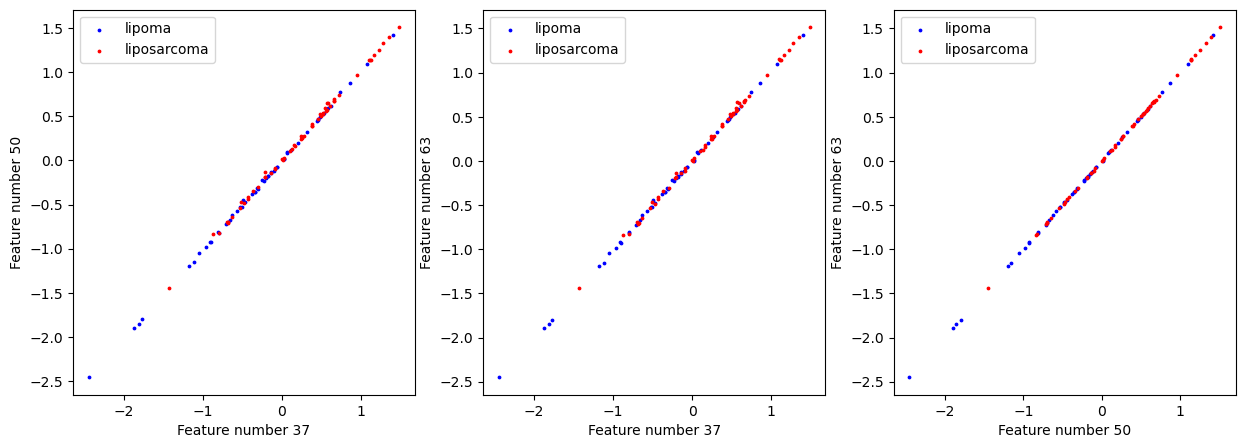

Training model: SVC, Model Accuracy: 0.8261
Training model: LinearDiscriminantAnalysis, Model Accuracy: 0.4348
Training model: QuadraticDiscriminantAnalysis, Model Accuracy: 0.7391


c:\Users\michi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\michi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [ ]:
# Data loading
data = load_data()
X_scaled = robust_scale(data[data.columns[1:]])
data[data.columns[1:]] = X_scaled


def normal_distribution(data):
    '''
    This function checks the normal distribution of features in the dataset and performs statistical tests.
    '''
    lipoma = data[data['label'] == 'lipoma']
    liposarcoma = data[data['label'] == 'liposarcoma']

    normally_distributed_features = []  # List to store normally distributed features
    statistically_significant_features = []  # List to store statistically significant features
    statistically_significant_features_number = []  # List to store statistically significant features number

    # Loop through all features (excluding the label column)

    for feature_number, feature in enumerate(data.columns[1:], start=1):
        selected_feature_lipoma = lipoma[feature]
        selected_feature_liposarcoma = liposarcoma[feature]

        # Shapiro-Wilk test for normality
        stat_lipoma, p_lipoma = shapiro(selected_feature_lipoma)
        stat_liposarcoma, p_liposarcoma = shapiro(selected_feature_liposarcoma)

        if p_lipoma > 0.05 and p_liposarcoma > 0.05:
            # print(f"Feature '{feature}' is normally distributed")
            normally_distributed_features.append(feature)

            # Perform t-test for statistical significance
            stat, p_value = stats.ttest_ind(selected_feature_lipoma, selected_feature_liposarcoma)

            # Correct for multiple comparisons (Bonferroni correction)
            p_value *= len(normally_distributed_features)
                           
            if p_value < 0.05:
                print(f"Feature '{feature}' is statistically significant (p-value: {p_value:.4f})")

                # Save the feature number
                statistically_significant_features.append(feature)
                statistically_significant_features_number.append(feature_number)
    return lipoma, liposarcoma, normally_distributed_features, statistically_significant_features, statistically_significant_features_number

# call the function
[lipoma, liposarcoma,
 normally_distributed_features,
 statistically_significant_features,
 statistically_significant_features_number] = normal_distribution(data)

# Plot scatter of statistically significant features
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[1]], color='blue', label='lipoma', s=3)
axis[0].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[1]], color='red', label='liposarcoma', s=3)
axis[0].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[0].set_ylabel(f"Feature number {statistically_significant_features_number[1]}")
axis[0].legend()

axis[1].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[1].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[1].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[1].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[1].legend()

axis[2].scatter(lipoma[statistically_significant_features[1]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[2].scatter(liposarcoma[statistically_significant_features[1]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[2].set_xlabel(f"Feature number {statistically_significant_features_number[1]}")
axis[2].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[2].legend()

plt.show()

# Train a logistic regression model with the statistically significant features

# Select the statistically significant features
X = data[statistically_significant_features]
y = data['label'].apply(lambda x: 1 if x == 'liposarcoma' else 0)  # Convert labels to binary (0 for lipoma, 1 for liposarcoma)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
models = [SVC(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
for model_instance in models:
    # Fit the model on the training data
    model_instance.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model_instance.predict(X_test)
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model_instance.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

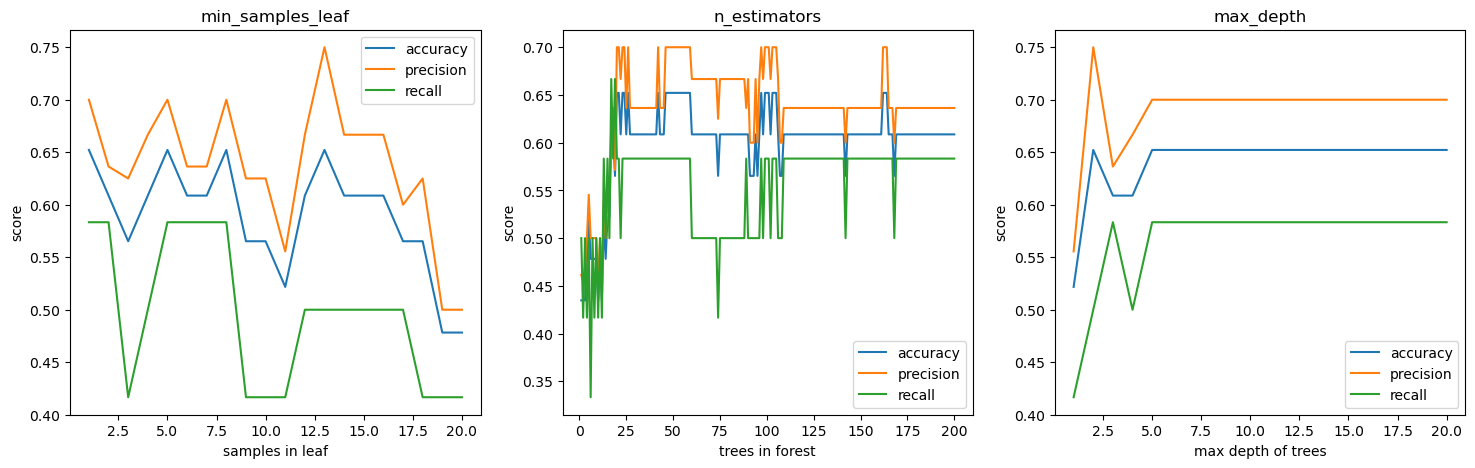

In [63]:
def test_hyperparameter(parameter,value_max):
    accuracy = []
    precision = []
    recall = []
    values = []
    for value in range(1,(value_max+1)):
        model_test = RandomForestClassifier(**{parameter: value}, random_state=42)
        model_test.fit(features_train, label_train)
        label_pred = model_test.predict(features_test)
        accuracy.append(accuracy_score(label_test, label_pred))
        precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
        recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        values.append(value)
    return accuracy,precision,recall,values

def plot_testing_values(axis, title,xlabel,ylabel,values,accuracy,precision,recall):
    axis.plot(values,accuracy, label='accuracy')
    axis.plot(values,precision, label='precision')
    axis.plot(values,recall, label='recall')
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    axis.legend()

data_lipoma = data[data['label'] == 'lipoma']
data_liposarcoma = data[data['label'] == 'liposarcoma']

split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]

fig, axis = plt.subplots(1,3, figsize=(18,5))
accuracy1, precision1, recall1, values1 = test_hyperparameter('min_samples_leaf', 20)
plot_testing_values(axis[0], 'min_samples_leaf','samples in leaf','score', values1, accuracy1, precision1, recall1)
accuracy2, precision2, recall2, values2 = test_hyperparameter('n_estimators', 200)
plot_testing_values(axis[1], 'n_estimators','trees in forest','score', values2, accuracy2, precision2, recall2)
accuracy3, precision3, recall3, values3 = test_hyperparameter('max_depth', 20)
plot_testing_values(axis[2], 'max_depth','max depth of trees','score', values3, accuracy3, precision3, recall3)

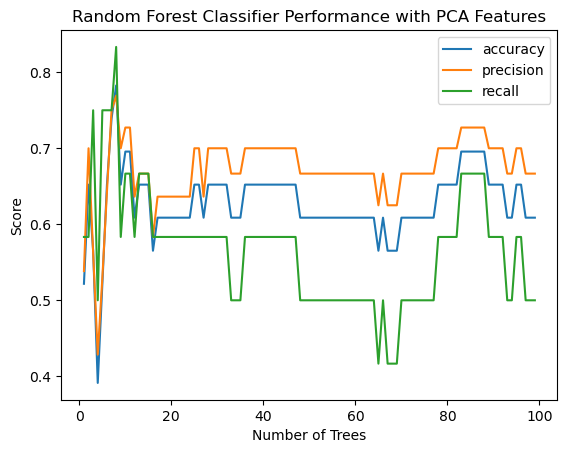

In [67]:
pca = PCA(n_components = 50)  # Keep 95% of variance
pca_transform = pca.fit_transform(data[data.columns[1:]])
data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
data_pca['label'] = data['label'].values  # Add the label column back to the PCA DataFrame

data_lipoma_pca = data_pca[data_pca['label'] == 'lipoma']
data_liposarcoma_pca = data_pca[data_pca['label'] == 'liposarcoma']

split_lipoma_pca = split_data(data_lipoma_pca)
split_liposarcoma_pca = split_data(data_liposarcoma_pca)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma_pca, split_liposarcoma_pca)
    ]

accuracy = []
precision = []
recall = []
tree = []
# Train the model with PCA features
for trees in range(1,100):
    model_test = RandomForestClassifier(min_samples_leaf=5, random_state=42, n_estimators=trees)
    model_test.fit(features_train, label_train)
    label_pred = model_test.predict(features_test)
    accuracy.append(accuracy_score(label_test, label_pred))
    precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
    recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
    tree.append(trees)

# Plot the results
fig, axis = plt.subplots()
axis.plot(tree,accuracy, label='accuracy')
axis.plot(tree,precision, label='precision')
axis.plot(tree,recall, label='recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Classifier Performance with PCA Features')
plt.legend()
plt.show()

In [77]:
import warnings

warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
# forward selection method
# sort the features by p-value
p_values = calculate_p_values(data)

data_p_values = pd.DataFrame(p_values, columns=['p_value'])
data_p_values['feature'] = data_p_values.index
data_p_values = data_p_values.reset_index(drop=True)

# Make a loop adding features one by one and check the accuracy of the model
features = []

# Initialize a DataFrame to store accuracy scores for each feature
accuracy_df = pd.DataFrame()
specificity_df = pd.DataFrame()
sensitivity_df = pd.DataFrame()

# Loop through features
for feature in range(0, 150):
    features.append(data_p_values['feature'][feature])
    features_train, features_test, label_train, label_test = train_test_split(data[features], data['label'], test_size=0.2, random_state=42, stratify=data['label'])
    
    # Store accuracy scores for the current feature
    accuracies = []
    specificities = []
    sensitivities = []
    for seed in range(10):
        param_dist = {'n_estimators': randint(1,150),
            'max_depth': randint(2,10),
            'min_samples_leaf': randint(3,10)}

        model = RandomForestClassifier(random_state=seed)

        rand_search = RandomizedSearchCV(model, 
                                        param_distributions = param_dist, 
                                        n_iter=5, 
                                        cv=5,
                                        random_state=42)
        rand_search.fit(features_train, label_train)
        best_rf = rand_search.best_estimator_
        label_pred = best_rf.predict(features_test)
        accuracies.append(accuracy_score(label_test, label_pred))
        specificities.append(recall_score(label_test, label_pred, pos_label='lipoma'))
        sensitivities.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
    
    # Add the accuracy scores as a column in the DataFrame
    accuracy_df[data_p_values['feature'][feature]] = accuracies
    specificity_df[data_p_values['feature'][feature]] = specificities
    sensitivity_df[data_p_values['feature'][feature]] = sensitivities



KeyboardInterrupt: 

Text(0.5, 1.0, 'Sensitivity')

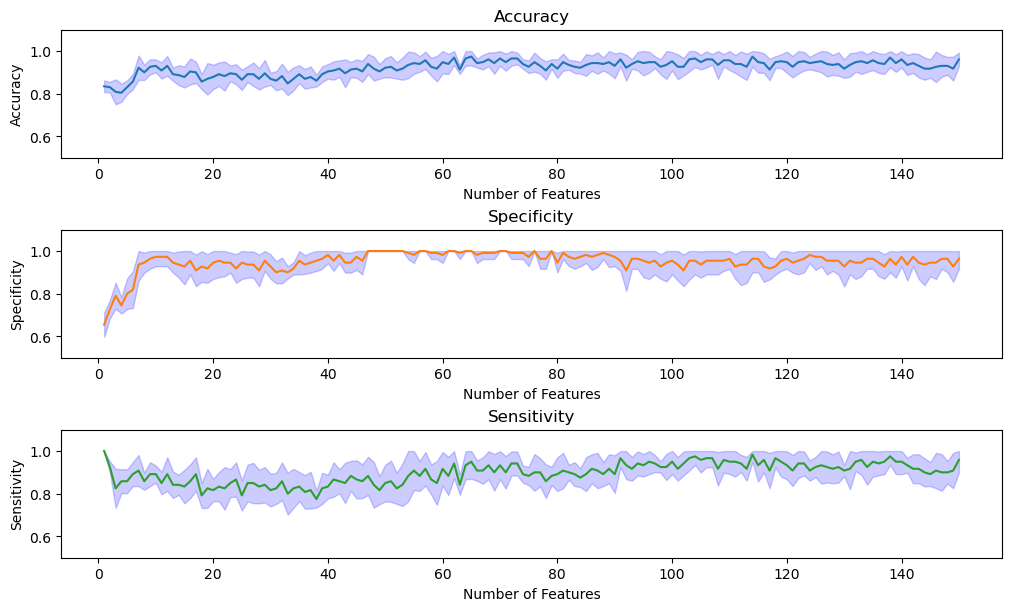

In [76]:
# plot the accuracy scores for each feature with a confidence interval
lower_bound_ac = (accuracy_df.mean() - accuracy_df.std())
upper_bound_ac = (accuracy_df.mean() + accuracy_df.std()).clip(upper=1)
lower_bound_sp = (specificity_df.mean() - specificity_df.std())
upper_bound_sp = (specificity_df.mean() + specificity_df.std()).clip(upper=1)
lower_bound_se = (sensitivity_df.mean() - sensitivity_df.std())
upper_bound_se = (sensitivity_df.mean() + sensitivity_df.std()).clip(upper=1)

fig, axis = plt.subplots(3, figsize=(10,6), constrained_layout=True)
axis[0].plot(range(1, accuracy_df.shape[1]+1), accuracy_df.mean(), label='accuracy', color='tab:blue')
axis[0].fill_between(range(1, accuracy_df.shape[1]+1), lower_bound_ac, upper_bound_ac, color='blue', alpha=0.2, label='+/- SD')
axis[0].set_xlabel('Number of Features')
axis[0].set_ylabel('Accuracy')
axis[0].set_ylim(0.5, 1.1)
axis[0].set_title('Accuracy')

axis[1].plot(range(1, specificity_df.shape[1]+1), specificity_df.mean(), label='specificity', color='tab:orange')
axis[1].fill_between(range(1, specificity_df.shape[1]+1), lower_bound_sp, upper_bound_sp, color='blue', alpha=0.2, label='+/- SD')
axis[1].set_xlabel('Number of Features')
axis[1].set_ylabel('Specificity')
axis[1].set_ylim(0.5, 1.1)
axis[1].set_title('Specificity')

axis[2].plot(range(1, sensitivity_df.shape[1]+1), sensitivity_df.mean(), label='sensitivity', color='tab:green')
axis[2].fill_between(range(1, sensitivity_df.shape[1]+1), lower_bound_se, upper_bound_se, color='blue', alpha=0.2, label='+/- SD')
axis[2].set_xlabel('Number of Features')
axis[2].set_ylabel('Sensitivity')
axis[2].set_ylim(0.5, 1.1)
axis[2].set_title('Sensitivity')